In [1]:
import os, pathlib, sys, shutil, random 
from tkinter import *
from PIL import ImageTk, Image
import numpy as np
import tensorflow as tf 
from tensorflow import keras
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt 
import pandas as pd
from sklearn.metrics import ConfusionMatrixDisplay,confusion_matrix

In [2]:
"""Create a directory for the species labels to be produced for sorting"""
species_list_dir = pathlib.Path("training_data/cropped_images")
unlabelled_dir = pathlib.Path("cm_dataset/unlabelled")
labelled_dir = pathlib.Path("cm_dataset/labelled")
sp_list = []
classes = []
for species in os.listdir(species_list_dir):
    sp_list.append(species) 
    """create a list of species from the training image directory, this will be used to compare the species prediction output to"""
    classes.append(species)
    """The classes list is a list to store the species labels to including a unknown/other category"""
classes.append("Other")
    

"""
Create a new directory where images put though the user labelling application will be sorted
in this current version of this script the function of this loop is redundant as we are not required to copy files into a
new directory
"""
for item in sp_list: 
    species_label_dir = labelled_dir/item
    if not os.path.exists(species_label_dir):
        os.makedirs(species_label_dir)


"""
Copy random images from data collection to be added to the unlabelled test dataset to be identified.
test_dataset_gen() loops through the root image directory and pulls out 1 image from each each date in all of the 
different locations and feed types
"""
def test_dataset_gen():
    root_dir = pathlib.Path("test_data")
    for location in os.listdir(root_dir):
        location_dir = root_dir/location
        for feed_type in os.listdir(location_dir):
            feed_type_dir = location_dir/feed_type/"date"
            for date in os.listdir(feed_type_dir):
                date_dir = feed_type_dir/date/"cropped_images"
                for i in range(0,1):
                    try:
                        file = random.choice(os.listdir(date_dir)) # random choice picks out a random file
                        original_path = date_dir/file # Define the original file path 
                        destination_path = unlabelled_dir/file # Define the new location the image will be copied too 
                        if not os.path.exists(destination_path): # Check if the image is already in the new directory, if it is present it will be skipped
                            shutil.copyfile(src=original_path, 
                                           dst=destination_path)
                    except:
                        pass

"""
Recall the model and weights both for the colour model and the black and white model as a back up, 
images are rescaled to the same sizes that were used when training the model. 
"""
def sp_predict_colour(image_name):
    new_model = load_model("Species_Classification_Model.h5")
    image_size = (200,200)
    test_image = os.path.abspath(unlabelled_dir/image_name)
    img = keras.preprocessing.image.load_img(
    test_image,target_size = image_size) # Resize the image
    img_array = keras.preprocessing.image.img_to_array(img)
    img_array = tf.expand_dims(img_array,0)
    pred = new_model.predict(img_array) 
    list = pred.flatten()
    probability = list*100 # Multiply the probability to create a percentage
    comp = {sp_list[i]:probability[i] for i in range(len(sp_list))} 
    dic = comp
    df = pd.DataFrame(probability,sp_list,columns=["Species Match (%)"]) # Create a dataframe storing the prediction name and % match 
    species = df.sort_values(by=["Species Match (%)"], ascending=False).round(2) # Re-order to decending species match (%)
    return species

"""
The exact same parameters are used in the black and white model except there is a preprocessing function to convert the 
input image into a greyscale (B/W) to then be compared with the black and white model. 
"""
def sp_predict_bw(image_name):
    new_model = load_model("Species_Classification_Model_Gray.h5")
    image_size = (200,200,1)
    test_image = os.path.abspath(unlabelled_dir/image_name)
    #print(test_image)
    img = keras.preprocessing.image.load_img(
    test_image,target_size = image_size)
    img = tf.image.rgb_to_grayscale(img)
    #plt.imshow(img)
    img_array = keras.preprocessing.image.img_to_array(img)
    img_array = tf.expand_dims(img_array,0)
    pred = new_model.predict(img_array) 
    list = pred.flatten()
    probability = list*100
    comp = {sp_list[i]:probability[i] for i in range(len(sp_list))}
    dic = comp
    df = pd.DataFrame(probability,sp_list,columns=["Species Match (%)"])
    species = df.sort_values(by=["Species Match (%)"], ascending=False).round(2)
    return species




In [3]:
test_dataset_csv = pd.read_csv("confusion_matrix.csv")
test_dataset_df = pd.DataFrame(test_dataset_csv)
image_number = test_dataset_df["Image"]
actual_species_list = test_dataset_df["True Species"]
predicted_species = test_dataset_df["Predicted Species"]

In [7]:
# TO DO Confine the app into a def function to be called upon to choose 
# Whether to add new labelled images or skip and produce a confusion matrix
# On current data in the dataframe
image_number = []
actual_species_list = []
predicted_species = []



"""
The following cell contains a fun interactive application which allows you to add new images to the test_dataset and then 
label the images whilst the the prediction models defined before, make a prediction to what species is in the image
"""
main = Tk() 
main.title("")
def Gen_Yes_Button(): # The test dataset gen button calls the train dataset gen function which copies random files from data collection 
    test_dataset_gen()
    main.destroy()
def Gen_No_Button(): # This button simply skips this window without adding new images into the test dataset directory
    main.destroy() # .destroy() destroys the window and breaks the .mainloop called below
Gen_Yes_Button = Button(main, text = "Gen Test Data", command = Gen_Yes_Button)
Gen_Yes_Button.pack()

Gen_No_Button = Button(main, text="Quit", command = Gen_No_Button)
Gen_No_Button.pack()

main.mainloop() # Runs the window 


"""
Loop through the test dataset directory and call upon the species predictor as well as the user labelling application
"""
for image in os.listdir(unlabelled_dir): 
    image_number.append(str(image))
    
    species = sp_predict_colour(image)
    species_pred = species.index[0]
    species_score = species["Species Match (%)"].iloc[0]
    print(species_pred,species_score)
    #predicted_species.append(species_pred)
    if species_score <= 50:
        species_bw = sp_predict_bw(image)
        species_pred_bw = species_bw.index[0]
        species_score_bw = species["Species Match (%)"].iloc[0]
        if species_score_bw < 70:
            predicted_species.append("Other")
        elif species_score_bw >= 70:
            for species in sp_list:
                if species_pred_bw == species:
                    predicted_species.append(species)
    elif species_score >50:
        for species in sp_list:
            if species_pred == species:
                predicted_species.append(species)
    
    original_path = pathlib.Path(unlabelled_dir/image)
    new_frame = Tk()
    new_frame.title("")
    img = Image.open(original_path)
    img = img.resize((500,500)) # Resize the image to standardise the image size in the window
    my_img = ImageTk.PhotoImage(img)
    label = Label(new_frame, image = my_img)
    label.pack()
    # The move_image funciton below is currently redundant but is a tool that can be used to copy the image to a species labelled folder
    """def move_image(original_path,sp_name): 
        destination_path = labelled_dir/sp_name/image
        if not os.path.exists(destination_path):
            shutil.copyfile(src=original_path,
                            dst=destination_path)
        new_frame.destroy()"""
    def actual_species(sp_name): 
        actual_species_list.append(sp_name) # Adds the name attached to the buttons below to a list of "actual species"
        new_frame.destroy()
        
    """
    A Series of buttons corresponding to species classifications that the model is trained on idenfying, there is also a 
    "Other" button which will classify the image as unknown where the animal/bird is not fully identifiable
    """
    Blackbird_Button = Button(new_frame, text = "Blackbird", command = lambda:(actual_species("Blackbird")))
    Blackbird_Button.pack()

    Blue_tit_Button = Button(new_frame, text = "Blue Tit", command = lambda:(actual_species("Blue tit")))
    Blue_tit_Button.pack() 

    Coal_tit_Button = Button(new_frame, text = "Coal Tit", command = lambda:(actual_species("Coal tit")))
    Coal_tit_Button.pack()

    Wood_pigeon_Button = Button(new_frame, text = "Wood Pigeon", command = lambda:(actual_species("Common Wood-pigeon")))
    Wood_pigeon_Button.pack()

    Squirrel_Button = Button(new_frame, text = "Eastern Gray Squirrel", command = lambda:(actual_species("Eastern gray squirrel")))
    Squirrel_Button.pack()

    Bullfinch_Button = Button(new_frame, text = "Eurasian Bullfinch", command = lambda:(actual_species("Eurasian bullfinch")))
    Bullfinch_Button.pack()

    Jay_Button = Button(new_frame, text = "Eurasian Jay", command = lambda:(actual_species("Eurasian jay")))
    Jay_Button.pack()

    Wren_Button = Button(new_frame, text = "Eurasian Wren", command = lambda:(actual_species("Eurasian wren")))
    Wren_Button.pack()

    #Goldfinch_Button = Button(new_frame, text = "European Goldfinch", command = lambda:(actual_species("European goldfinch")))
    #Goldfinch_Button.pack()

    Robin_Button = Button(new_frame, text = "European Robin", command = lambda:(actual_species("European robin")))
    Robin_Button.pack()

    #Woodpecker_Button = Button(new_frame, text = "Great Spotted Woodpecker", command = lambda:(actual_species("Great spotted woodpecker")))
    #Woodpecker_Button.pack()

    Great_tit_Button = Button(new_frame, text = "Great Tit", command = lambda:(actual_species("Great tit")))
    Great_tit_Button.pack()

    Long_tailed_tit_Button = Button(new_frame, text = "Long-tailed Tit", command = lambda:(actual_species("Long-tailed tit")))
    Long_tailed_tit_Button.pack()

    Nuthatch_Button = Button(new_frame, text = "Nuthatch", command = lambda:(actual_species("Nuthatch")))
    Nuthatch_Button.pack()

    Roe_deer_Button = Button(new_frame, text = "Western Roe Deer", command = lambda:(actual_species("Western roe deer")))
    Roe_deer_Button.pack()

    Other_Button = Button(new_frame, text = "Other", command = lambda:(actual_species("Other")))
    Other_Button.pack()
    def Exit():
        new_frame.destroy()
    Exit_Button = Button(new_frame, text = "Exit", command =Exit )
    Exit_Button.pack()
    new_frame.attributes("-fullscreen", True) # Opens the application in full screen.
    new_frame.mainloop()


1/1 [==============================] - 4s 4s/step
Eastern gray squirrel 53.76
1/1 [==============================] - 0s 141ms/step
Great tit 55.33
1/1 [==============================] - 0s 141ms/step
Great tit 35.77
1/1 [==============================] - 0s 156ms/step
Eastern gray squirrel 61.51
1/1 [==============================] - 0s 142ms/step
Blue tit 61.49
1/1 [==============================] - 0s 143ms/step
Eastern gray squirrel 28.72
1/1 [==============================] - 0s 172ms/step
Coal tit 68.65
1/1 [==============================] - 0s 141ms/step
Great tit 99.59
1/1 [==============================] - 0s 142ms/step
Nuthatch 38.59
1/1 [==============================] - 0s 251ms/step
Great tit 90.44
1/1 [==============================] - 0s 145ms/step
Coal tit 33.17
1/1 [==============================] - 0s 141ms/step
Great tit 97.3
1/1 [==============================] - 0s 150ms/step
Great tit 56.79
1/1 [==============================] - 0s 141ms/step
Great tit 98.88
1/1 [=

1/1 [==============================] - 0s 145ms/step
Great tit 76.03
1/1 [==============================] - 0s 151ms/step
Eastern gray squirrel 20.76
1/1 [==============================] - 0s 169ms/step
Blue tit 50.38
1/1 [==============================] - 0s 145ms/step
Coal tit 90.04
1/1 [==============================] - 0s 140ms/step
Western roe deer 39.13
1/1 [==============================] - 0s 148ms/step
Nuthatch 23.77
1/1 [==============================] - 0s 144ms/step
Great tit 63.32
1/1 [==============================] - 0s 148ms/step
Nuthatch 51.54
1/1 [==============================] - 0s 149ms/step
Eastern gray squirrel 81.86
1/1 [==============================] - 0s 150ms/step
Nuthatch 41.99
1/1 [==============================] - 0s 140ms/step
Great tit 87.99
1/1 [==============================] - 0s 141ms/step
Eastern gray squirrel 99.22
1/1 [==============================] - 0s 139ms/step
Coal tit 72.04
1/1 [==============================] - 0s 140ms/step
Coal tit 98.0

1/1 [==============================] - 0s 157ms/step
Blue tit 50.02
1/1 [==============================] - 0s 139ms/step
Common Wood-pigeon 76.17
1/1 [==============================] - 0s 150ms/step
Common Wood-pigeon 45.34
1/1 [==============================] - 0s 149ms/step
Blue tit 72.4
1/1 [==============================] - 0s 149ms/step
Coal tit 100.0
1/1 [==============================] - 0s 150ms/step
Great tit 89.79
1/1 [==============================] - 0s 275ms/step
Great tit 58.53
1/1 [==============================] - 0s 159ms/step
Blue tit 98.59
1/1 [==============================] - 0s 149ms/step
Great tit 76.26
1/1 [==============================] - 0s 151ms/step
Eastern gray squirrel 64.36
1/1 [==============================] - 0s 149ms/step
Nuthatch 68.25
1/1 [==============================] - 0s 151ms/step
Great tit 72.9
1/1 [==============================] - 0s 140ms/step
Nuthatch 82.81
1/1 [==============================] - 0s 142ms/step
Blackbird 82.45
1/1 [=======

In [10]:
"""Stores the image file name and true species identification and predicted identificaiton into a 
dataframe which can be recalled later if needed"""
cm_dic = {"Image":image_number,
     "True Species":actual_species_list,
     "Predicted Species": predicted_species}
cm_df = pd.DataFrame(cm_dic)
display(cm_df)
cm_df.to_csv("confusion_matrix.csv")

,Image,True Species,Predicted Species
0,01020002.JPG___crop00_md_v5a.0.0.pt.jpg,Blue tit,Eastern gray squirrel
1,01020003.JPG___crop00_md_v5a.0.0.pt.jpg,Great tit,Great tit
2,01020003.JPG___crop01_md_v5a.0.0.pt.jpg,Great tit,Other
3,01020004.JPG___crop00_md_v5a.0.0.pt.jpg,Other,Eastern gray squirrel
4,01020045.JPG___crop00_md_v5a.0.0.pt.jpg,Blue tit,Blue tit
...,...,...,...
375,12250758.JPG___crop00_md_v5a.0.0.pt.jpg,Eastern gray squirrel,Eastern gray squirrel
376,12270384.JPG___crop00_md_v5a.0.0.pt.jpg,European robin,Eastern gray squirrel
377,12270763.JPG___crop00_md_v5a.0.0.pt.jpg,Other,Other
378,12280386.JPG___crop00_md_v5a.0.0.pt.jpg,Eastern gray squirrel,Other


In [14]:
test_dataset_csv = pd.read_csv("confusion_matrix.csv")
test_dataset_df = pd.DataFrame(test_dataset_csv)
image_number = test_dataset_df["Image"]
actual_species_list = test_dataset_df["True Species"]
predicted_species = test_dataset_df["Predicted Species"]

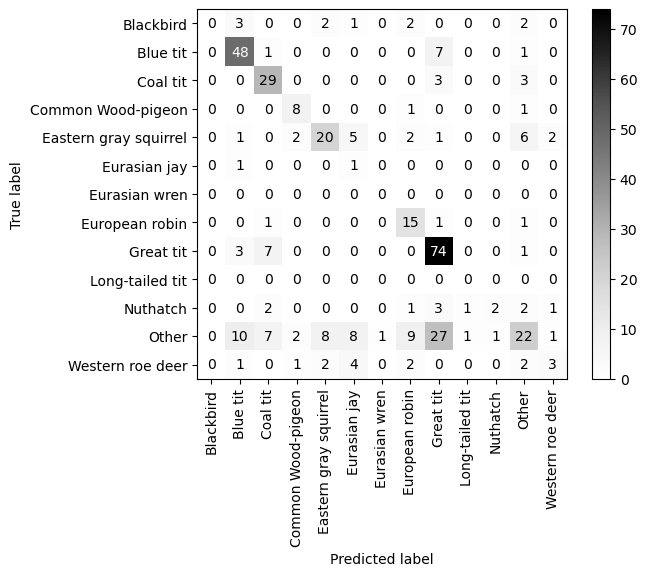

In [15]:
"""Create a Confusion matrix which allows the true accuracy of the species classification model on live test data"""
y_pred = predicted_species
y_test = actual_species_list
labels = classes

cm = confusion_matrix(y_test, y_pred)

ConfusionMatrixDisplay.from_predictions(y_pred,y_test,xticks_rotation = "vertical", cmap = plt.cm.Greys)
plt.savefig("Test_Dataset_Confusion_Matrix.png", bbox_inches="tight")


In [40]:
"""
This cell contains how to produce the F-score as well as other accuracy measures of the confusion matrix 
"""
from sklearn import metrics
sorted_cm_species = ["Blackbird","Blue tit","Coal tit","Common Wood-pigeon","Eastern grey squirrel","Eurasian jay",
                    "Eruasian wren","European robin","Great tit","Long-tailed tit","Nuthatch","Other","Western roe deer"]
print(sorted_cm_species)
# Accuracy 
Accuracy = metrics.accuracy_score(y_test,y_pred)
print(Accuracy)
# Precision
Precision = metrics.precision_score(y_test,y_pred,average = None)
print(Precision)
# F-score
F1_score = metrics.f1_score(y_test,y_pred, average = None)
print(len(F1_score))
F1_score_df = pd.DataFrame(F1_score)
df = pd.DataFrame({"Species":sorted_cm_species,"F1_score":F1_score})
display(df)
df.to_csv("F1_scores.csv", index = False)

['Blackbird', 'Blue tit', 'Coal tit', 'Common Wood-pigeon', 'Eastern grey squirrel', 'Eurasian jay', 'Eruasian wren', 'European robin', 'Great tit', 'Long-tailed tit', 'Nuthatch', 'Other', 'Western roe deer']
0.5842105263157895
[0.         0.84210526 0.82857143 0.8        0.51282051 0.5
 0.         0.83333333 0.87058824 0.         0.16666667 0.22680412
 0.2       ]
13


C:\Users\vince\anaconda3\envs\cameratraps-detector\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,Species,F1_score
0,Blackbird,0.000000
1,Blue tit,0.774194
2,Coal tit,0.707317
3,Common Wood-pigeon,0.695652
4,Eastern grey squirrel,0.563380
5,Eurasian jay,0.095238
6,Eruasian wren,0.000000
7,European robin,0.600000
8,Great tit,0.736318
9,Long-tailed tit,0.000000
